# Importing packages 


In [2]:
# Array math 
import numpy as np 

# Typehinting
from typing import Tuple

# Plotting
import matplotlib.pyplot as plt
import matplotlib

# Q Learning 

Q learning is an off-policy TD algorithm to approximate the best optimal policy. 

Definitions: 

*Q value* - the value given for an action $a$ taken in state $s$. To put it more mathematically, it maps the actions and states to the real number plane: 

$$Q(a \in \mathbb{A}, s \in \mathbb{S}) \rightarrow q \in  \mathbb{R}$$

In practise, the bigger the q value for an action is, the "better" it is for the agent to take. 

*Q table* - a matrix storing the Q values where each row is a state and each column is an action. 

*$\epsilon$-greedy policy* - the policy where, at every decision point, the agent takes a random action with the probability of 1 - $\epsilon$ and the action which has the biggest q value with the probability of $\epsilon$, where $\epsilon \in [0, 1]$.

*off-policy algorithm* - algorithms where the agent updates it's policy not using it's behavior policy. 

*behavior policy* - the policy used by the agent to make an action.

Full algorithm for Q learning: 

1. Hyperparameters: 

1.1 Define step size $\alpha \in (0, 1]$

1.2 Define $\epsilon \in [0, 1]$

1.3 Define the discount factor $\gamma \in (0, 1]$

1.4 Initialize the Q table where all the values are arbitraty except for terminal states $Q(terminal, *) = 0$

1.5 Define the number of episodes $N$. 

2. Iterate for 1 to $N$:

2.1 Pick a starting state s.

2.2 Iterate until the agent reaches a terminal state: 

2.2.1 From the given state, pick an action $A$ using epsilon-greedy policy 

2.2.2 Take action $A$, observe the transition state $s^{'}$ and the reward $r$

**2.2.3 Update the current Q value estimate:** 

$$ Q(S, A) \leftarrow Q(S, A) + \alpha \left(r + \gamma \max_{a} Q(s^{'}, a) - Q(S, A)\right)$$

2.2.4 Set $s$ $\leftarrow$ $s^{'}$

The 2.2.3 update is the main part of the Q algorithm. 

As we can see, in step 2.2.1, the behavior policy is the epslion-greedy policy. 

But when we update the current Q value, we do not use that behaviour policy - we update the current Q value from the future state Q value and not use the epsilon-greedy policy anywhere. 

# Maze escape problem 

We will create a maze where: 

The agent starts at the bottom left corner of the maze. 

The goal is to reach the top right corner of the maze. 

In the middle of the maze we will generate some random wall blocks. 

When an agent tries to transition to a wall block, it will stay in the same state with a reward of -1. 

Every movement will give a reward of -0.1.

Reaching the goal state terminates the episode and returns a reward of 1. 

# Defining the ploting functions 

In [23]:
def array_index_to_matplot_coords(i: int, j: int, n_cols: int) -> Tuple[int, int]:
    """Converts an array index to a matplot coordinate"""
    x = j
    y = n_cols - i - 1
    return x, y

def plot_matrix(
    M: np.array, 
    goal_coords: list = [],
    hole_coords: list = [],
    start_coords: list = [],
    img_width: int = 5, 
    img_height: int = 5, 
    title: str = None,
    ) -> None: 
    """
    Plots a matrix as an image.
    """
    height, width = M.shape

    fig = plt.figure(figsize=(img_width, img_width))
    ax = fig.add_subplot(111, aspect='equal')
    
    for x in range(height):
        for y in range(width):
            # By default, the (0, 0) coordinate in matplotlib is the bottom left corner,
            # so we need to invert the y coordinate to plot the matrix correctly
            matplot_x, matplot_y = array_index_to_matplot_coords(x, y, height)
            
            # If there is a tuple of (x, y) in the goal_coords list, we color the cell gray 
            if (x, y) in goal_coords:
                ax.add_patch(matplotlib.patches.Rectangle((matplot_x - 0.5, matplot_y - 0.5), 1, 1, facecolor='lightgreen'))
            # If there is a tuple of (x, y) in the hole_coords list, we color the cell salmon
            elif (x, y) in hole_coords:
                ax.add_patch(matplotlib.patches.Rectangle((matplot_x - 0.5, matplot_y - 0.5), 1, 1, facecolor='salmon'))
            # If there is a tuple of (x, y) in the start_coords list, we color the cell yellow
            elif (x, y) in start_coords:
                ax.add_patch(matplotlib.patches.Rectangle((matplot_x - 0.5, matplot_y - 0.5), 1, 1, facecolor='yellow'))

            ax.annotate(str(M[x][y]), xy=(matplot_x, matplot_y), ha='center', va='center')

    offset = .5    
    ax.set_xlim(-offset, width - offset)
    ax.set_ylim(-offset, height - offset)

    ax.hlines(y=np.arange(height+1)- offset, xmin=-offset, xmax=width-offset)
    ax.vlines(x=np.arange(width+1) - offset, ymin=-offset, ymax=height-offset)

    plt.title(title)
    plt.show()


# Defining the maze world 

In [30]:
def get_state_coords(s, S) -> tuple:
    """
    Returns the state coordinates given the state index
    """
    s_index = np.where(S == s)
    return s_index[0][0], s_index[1][0]

def init_maze(nrow: int, ncol: int, maze_density: int, seed: int) -> Tuple:
    """
    Creates an array of states in a maze environment.

    Returns
    -------
    maze : np.array
        A 2D array of states in a maze environment.
    wall_coords : list
        A 1D array of wall states in the maze environment.
    start_coords: tuple
        A tuple of start coordinates in the maze environment.
    goal_coords: tuple
        A tuple of goal coordinates in the maze environment.
    """
    # Setting the seed for reproducibility
    np.random.seed(seed)

    # Initiating the empty maze
    maze = np.arange(0, nrow * ncol).reshape(nrow, ncol)

    # Creating the wall states
    wall_states = np.random.choice(range(1, nrow * ncol), size=maze_density, replace=False)

    # Getting the list of wall coordinates
    wall_coords = [get_state_coords(s, maze) for s in wall_states]

    # Generating a starting state from the states that are NOT walls
    start_state = np.random.choice(np.setdiff1d(maze, wall_states))

    # Getting the starting coordinates
    start_coords = get_state_coords(start_state, maze)

    # Generating a goal state from the states that are NOT walls and NOT the starting state
    goal_state = np.random.choice(np.setdiff1d(np.setdiff1d(maze, wall_states), start_state))

    # Getting the goal coordinates
    goal_coords = get_state_coords(goal_state, maze)

    # return maze, wall_states
    return maze, wall_coords, [start_coords], [goal_coords]

In [39]:
maze, walls, start, goal = init_maze(6, 6, 8, 40)

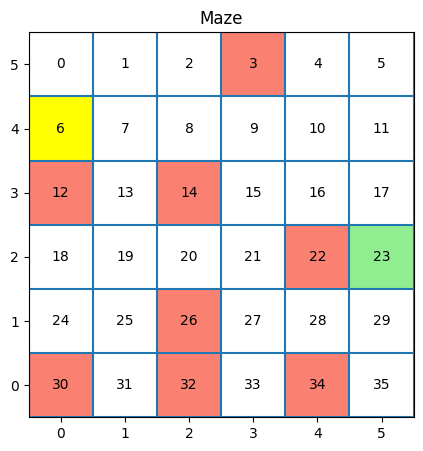

In [40]:
plot_matrix(maze, goal_coords=goal, hole_coords=walls, start_coords=start, title="Maze")